
This ipython notebook calculates the numerical diffusivity on a tracer, associated to a specific configuration of the MITgcm. In particular, 
it was developed to calculate the equavalent diffusivity $\kappa$, defined (here) as $\kappa = \kappa_{pres}+\kappa_{num}$, where $\kappa_{pres}$ 
is the prescibed or explicit tracer diffusivity one imposes on the model and $k_{num}$ is the additional diffusivity due to numerical truncation errors. Note that there are two $\kappa_{pres}$ and therefore two $\kappa$, one for the horizontal dimensions and one for the vertical one.

These calculations try to reproduce the method used by [1] Abernathy et al. 2010, [2] Hill et al. 2011, [3] Leibensperger and Plumb, 2013 to determine
the numerical diffusivity in MITgcm Southern Ocean configurations [1,2] and a baroclinic flow simulation [3].

The method goes as follows:

From the evolution equation for the variance of the tracer concentration in the model output

$\frac{1}{2}\frac{\partial{<q_h^{2}>}}{\partial{t}}=-\kappa_{h} <(\nabla_h q)^2>-\kappa_{v} <(\frac{\partial{q}}{\partial {z}})^{2}>$

one can fit by a least squares regression, suitable values of $\kappa_h$ and $\kappa_v$ that satisfy the equation.

In [259]:
#KRM
import os

import numpy as np

import matplotlib.pyplot as plt

from scipy.stats import nanmean

from math import *

%matplotlib inline

import numpy as np

import matplotlib.colors as mcolors

from netCDF4 import Dataset

import pylab as pl


FUNCTIONS:

In [260]:
#'''
#NAME
#    Custom Colormaps for Matplotlib
#PURPOSE
#    This program shows how to implement make_cmap which is a function that
#    generates a colorbar.  If you want to look at different color schemes,
#    check out https://kuler.adobe.com/create.
#PROGRAMMER(S)
#    Chris Slocum
#REVISION HISTORY
#    20130411 -- Initial version created
#    20140313 -- Small changes made and code posted online
#    20140320 -- Added the ability to set the position of each color
#'''

def make_cmap(colors, position=None, bit=False):
    #'''
    #make_cmap takes a list of tuples which contain RGB values. The RGB
    #values may either be in 8-bit [0 to 255] (in which bit must be set to
    #rue when called) or arithmetic [0 to 1] (default). make_cmap returns
    #a cmap with equally spaced colors.
    #Arrange your tuples so that the first color is the lowest value for the
    #colorbar and the last is the highest.
    #position contains values from 0 to 1 to dictate the location of each color.
    #'''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

In [261]:
# Get field from MITgcm netCDF output
#
# statefile : string with /path/to/state.0000000000.t001.nc
# fieldname : string with the variable name as written on the netCDF file ('Temp', 'S','Eta', etc.)
#
def getField(statefile, fieldname):
    
    StateOut = Dataset(statefile)
    
    Fld = StateOut.variables[fieldname][:]
    
    shFld = np.shape(Fld)
    
    if len(shFld) == 1:
        
        return Fld
    
    elif len(shFld) == 2:
        
        Fld2 = np.reshape(Fld,(shFld[0],shFld[1])) # reshape to pcolor order
        return Fld2 
    
    elif len(shFld) == 3:
        
        Fld2 = np.zeros((shFld[0],shFld[1],shFld[2])) 
        Fld2 = np.reshape(Fld,(shFld[0],shFld[1],shFld[2])) # reshape to pcolor order
        return Fld2 
        
    elif len(shFld) == 4:
        
        Fld2 = np.zeros((shFld[0],shFld[1],shFld[2],shFld[3])) 
        Fld2 = np.reshape(Fld,(shFld[0],shFld[1],shFld[2],shFld[3])) # reshape to pcolor order
        return Fld2
        
    else:
        
        print (' Check size of field ')
    
    


BEGIN CALCULATIONS:

In [262]:

### Load output filenames ###

filename = '/ocean/kramosmu/MITgcm/CanyonUpwelling/480x360x43_UpwLinRampWind_4Tr_BCC/output_0001/state.0000000000.glob.nc'
StateOut = Dataset(filename)

filename2 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/480x360x43_UpwLinRampWind_4Tr_BCC/output_0001/grid.glob.nc'
GridOut = Dataset(filename2)
#for dimobj in GridOut.variables.values():
#    print dimobj
filename3 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/480x360x43_UpwLinRampWind_4Tr_BCC/output_0001/ptracers.0000000000.glob.nc'
PtracersOut = Dataset(filename3)


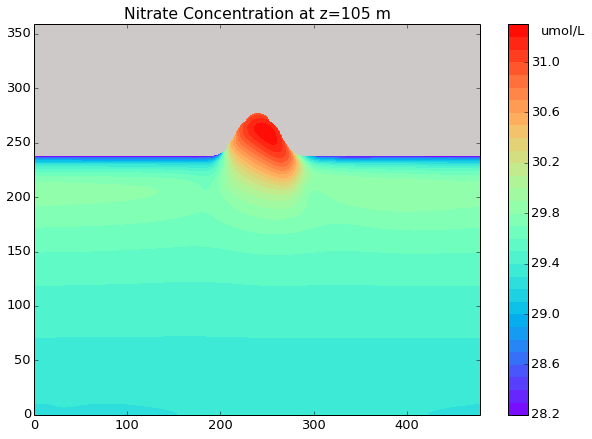

In [264]:
plt.rcParams.update({'font.size':13})

tracer1=getField(filename3,'NO3')

tracer1msk = np.ma.masked_values(tracer1, 0)

MASK = np.ma.getmask(tracer1msk)

### PLOT TRACER 1 at zlev and time###

zlev =10
time =20

plt.figure(figsize=(10,7))

ax=plt.gca()
ax.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))

plt.contourf(tracer1msk[time,zlev,:,:],30, cmap='rainbow')
cb = plt.colorbar()
cb.set_label('umol/L', position=(0, 1),rotation=0)

z=StateOut.variables['Z']

plt.title("Nitrate Concentration at z=%d m" % -z[zlev])





Now, let's calculate the mean concentration at t=0 (for the whole volume). The volume of a tracer cell (remember we have an Arakawa C grid, so this changes depending on which kind of cell we are thinking about) is given by

$V(i,j,k)=depth \times area = (hfacC(i,j,k)\times dRf(k)) \times rA(i,j) = (hfacC(i,j,k)\times dRf(k)) \times dXg(i,j) \times dYg(i,j)$,

where hfacC is the fraction of the cell that is open (not occupied with land). So, the total volume of the domain is 

$\sum\limits_{i=1}^{nx}{\sum\limits_{j=1}^{ny}{\sum\limits_{k=1}^{nz}{(hfacC(i,j,k)\times dRf(k)) \times rA(i,j)}}}$

In [265]:
nx = 480 # number of x points in domain
ny = 360  #           y points
nz = 43  #           z levels
nt = 37  # n time 

DomVolume = 0.0

hFacC = getField(filename2,'HFacC')
drF   = getField(filename2,'drF')
rAC   = getField(filename2,'rA')


for ii in np.arange(nx):
    
    for jj in np.arange(ny):
        
        for kk in np.arange(nz):
            
            DomVolume = DomVolume + hFacC[kk,jj,ii]*drF[kk]*rAC[jj,ii]

print('\n The total volume is %e m^3 \n' %DomVolume)


 The total volume is 6.077434e+12 m^3 



The mean (first moment, expected value, etc) of the descrete concentration $q$ is

$<q>\approx\frac{1}{V}\sum\limits_{i=1}^{nx}{\sum\limits_{j=1}^{ny}{\sum\limits_{k=1}^{nz}{q(i,j,k)}}}$, 

and the variance (second moment) of $q$ is

$<q^2>=<(q-<q>)^2>\approx \frac{1}{V}\sum\limits_{i=1}^{nx}{\sum\limits_{j=1}^{ny}{\sum\limits_{k=1}^{nz}{(q(i,j,k)-<q>)^2}}}$.



In [266]:
## Calculate the mean

qmean = np.zeros((nt,1))

for tt in np.arange(nt):
    qsum = 0.0
    for ii in np.arange(nx):
        
        for jj in np.arange(ny):
            
            for kk in np.arange(nz):
                
                qsum = qsum + tracer1[tt,kk,jj,ii]
                
    qmean[tt] = qsum/DomVolume
    print('Mean q at nt=%d is %e umol/l \n' %(tt, qmean[tt]))

qmeanTemp = fsum(qmean[:])/nt

print('\n Mean q is %e umol/lm^3 \n' %qmeanTemp)
            





Mean q at nt=0 is 2.313253e-05 umol/l 

Mean q at nt=1 is 2.313900e-05 umol/l 

Mean q at nt=2 is 2.315163e-05 umol/l 

Mean q at nt=3 is 2.316375e-05 umol/l 

Mean q at nt=4 is 2.317576e-05 umol/l 

Mean q at nt=5 is 2.318754e-05 umol/l 

Mean q at nt=6 is 2.319908e-05 umol/l 

Mean q at nt=7 is 2.321052e-05 umol/l 

Mean q at nt=8 is 2.322183e-05 umol/l 

Mean q at nt=9 is 2.323281e-05 umol/l 

Mean q at nt=10 is 2.324375e-05 umol/l 

Mean q at nt=11 is 2.325465e-05 umol/l 

Mean q at nt=12 is 2.326544e-05 umol/l 

Mean q at nt=13 is 2.327608e-05 umol/l 

Mean q at nt=14 is 2.328666e-05 umol/l 

Mean q at nt=15 is 2.329712e-05 umol/l 

Mean q at nt=16 is 2.330749e-05 umol/l 

Mean q at nt=17 is 2.331781e-05 umol/l 

Mean q at nt=18 is 2.332803e-05 umol/l 

Mean q at nt=19 is 2.333820e-05 umol/l 

Mean q at nt=20 is 2.334830e-05 umol/l 

Mean q at nt=21 is 2.335834e-05 umol/l 

Mean q at nt=22 is 2.336831e-05 umol/l 

Mean q at nt=23 is 2.337821e-05 umol/l 

Mean q at nt=24 is 2.33880

Ideally, mean q should be constant in time!!! Why is it increasing?

In [267]:
### Calculate the variance

qvar = np.zeros((nt,1))

for tt in np.arange(nt):
    qvarsum = 0.0
    for ii in np.arange(nx):
        
        for jj in np.arange(ny):
            
            for kk in np.arange(nz):
                
                qvarsum = qvarsum + (tracer1[tt,kk,jj,ii]-qmeanTemp
                                     )**2
                
    qvar[tt] = qvarsum/DomVolume
    print('Variance of q at nt=%d is %e umol^2/lm^3 \n' %(tt, qvar[tt]))




            



Variance of q at nt=0 is 8.044119e-04 umol^2/lm^3 

Variance of q at nt=1 is 8.021757e-04 umol^2/lm^3 

Variance of q at nt=2 is 8.010232e-04 umol^2/lm^3 

Variance of q at nt=3 is 8.002406e-04 umol^2/lm^3 

Variance of q at nt=4 is 7.996959e-04 umol^2/lm^3 

Variance of q at nt=5 is 7.993043e-04 umol^2/lm^3 

Variance of q at nt=6 is 7.990194e-04 umol^2/lm^3 

Variance of q at nt=7 is 7.988258e-04 umol^2/lm^3 

Variance of q at nt=8 is 7.987020e-04 umol^2/lm^3 

Variance of q at nt=9 is 7.986219e-04 umol^2/lm^3 

Variance of q at nt=10 is 7.985919e-04 umol^2/lm^3 

Variance of q at nt=11 is 7.986062e-04 umol^2/lm^3 

Variance of q at nt=12 is 7.986532e-04 umol^2/lm^3 

Variance of q at nt=13 is 7.987261e-04 umol^2/lm^3 

Variance of q at nt=14 is 7.988265e-04 umol^2/lm^3 

Variance of q at nt=15 is 7.989477e-04 umol^2/lm^3 

Variance of q at nt=16 is 7.990877e-04 umol^2/lm^3 

Variance of q at nt=17 is 7.992469e-04 umol^2/lm^3 

Variance of q at nt=18 is 7.994212e-04 umol^2/lm^3 

Var

The variances of the descrete concentration derivatives are approximated by:

$<(\frac{\partial{q}}{\partial{z}})^2> = <(\frac{\partial{q}}{\partial{z}}-<\frac{\partial{q}}{\partial{z}}>)^2> \approx \frac{1}{V}\sum\limits_{i=1}^{nx}{\sum\limits_{j=1}^{ny}{\sum\limits_{k=1}^{nz}{(\frac{\Delta q(i,j,k)}{\Delta z(i,j,k)}-<\frac{\partial{q}}{\partial{z}}>)^2}}}  $

and

$ <|\nabla_h{q}|^2> = <(\sqrt{(\frac{\partial{q}}{\partial{x}})^2+(\frac{\partial{q}}{\partial{y}})^2}-<|\nabla_h{q}|>)^2> \approx \frac{1}{V}\sum\limits_{i=1}^{nx}{\sum\limits_{j=1}^{ny}{\sum\limits_{k=1}^{nz}{(\sqrt{(\frac{\Delta{q(i,j,k)}}{\Delta{x(i,j,k)}})^2+(\frac{\Delta{q(i,j,k)}}{\Delta{y(i,j,k)}})^2}-<|\nabla_h{q}|>)^2}}}$. 

Here, the means are approximated respectively as:

$<\frac{\partial{q}}{\partial{z}}> \approx \frac{1}{V}\sum\limits_{i=1}^{nx}{\sum\limits_{j=1}^{ny}{\sum\limits_{k=1}^{nz}{\frac{\Delta q(i,j,k)}{\Delta z(i,j,k)}}}}  $

and

$ <|\nabla_h{q}|> \approx \frac{1}{V}\sum\limits_{i=1}^{nx}{\sum\limits_{j=1}^{ny}{\sum\limits_{k=1}^{nz}{(\sqrt{(\frac{\Delta{q(i,j,k)}}{\Delta{x(i,j,k)}})^2+(\frac{\Delta{q(i,j,k)}}{\Delta{y(i,j,k)}})^2}}}}$. 

In [268]:
### Calculate mean of dq/dz

qmeanDz = np.zeros((nt,1))

for tt in np.arange(nt):
    qsumDz = 0.0
    for ii in np.arange(nx):
        
        for jj in np.arange(ny):
            
            for kk in np.arange(nz-1):
                
                if hFacC[kk,jj,ii]*drF[kk]-hFacC[kk+1,jj,ii]*drF[kk+1] == 0:
                    
                    continue
                    
                else :
                    
                    qsumDz = qsumDz + (tracer1[tt,kk,jj,ii]-tracer1[tt,kk+1,jj,ii])/(hFacC[kk,jj,ii]*drF[kk]-hFacC[kk+1,jj,ii]*drF[kk+1])
                
    qmeanDz[tt] = qsumDz/DomVolume
    print('Mean dq/dz at nt=%d is %e \n' %(tt, qmeanDz[tt]))

qmeanDzTemp = fsum(qmeanDz[:])/nt

print('\n Mean dq/dz is %e \n' %qmeanDzTemp)
            




Mean dq/dz at nt=0 is 8.345292e-07 

Mean dq/dz at nt=1 is 8.243916e-07 

Mean dq/dz at nt=2 is 8.151873e-07 

Mean dq/dz at nt=3 is 8.056777e-07 

Mean dq/dz at nt=4 is 7.963681e-07 

Mean dq/dz at nt=5 is 7.876711e-07 

Mean dq/dz at nt=6 is 7.790698e-07 

Mean dq/dz at nt=7 is 7.704833e-07 

Mean dq/dz at nt=8 is 7.619164e-07 

Mean dq/dz at nt=9 is 7.535288e-07 

Mean dq/dz at nt=10 is 7.453980e-07 

Mean dq/dz at nt=11 is 7.372204e-07 

Mean dq/dz at nt=12 is 7.291671e-07 

Mean dq/dz at nt=13 is 7.213374e-07 

Mean dq/dz at nt=14 is 7.135480e-07 

Mean dq/dz at nt=15 is 7.057611e-07 

Mean dq/dz at nt=16 is 6.981267e-07 

Mean dq/dz at nt=17 is 6.905859e-07 

Mean dq/dz at nt=18 is 6.830313e-07 

Mean dq/dz at nt=19 is 6.755671e-07 

Mean dq/dz at nt=20 is 6.682245e-07 

Mean dq/dz at nt=21 is 6.609031e-07 

Mean dq/dz at nt=22 is 6.536242e-07 

Mean dq/dz at nt=23 is 6.464471e-07 

Mean dq/dz at nt=24 is 6.393181e-07 

Mean dq/dz at nt=25 is 6.322103e-07 

Mean dq/dz at nt=26 is

In [269]:
### Calculate mean of sqrt((dq/dx)^2 + (dq/dy)^2)

dxG = getField(filename2,'dxG')
dyG = getField(filename2,'dyG')

qmeanDh = np.zeros((nt,1))

for tt in np.arange(nt):
    qsumDh = 0.0
    for ii in np.arange(nx-1):
        
        for jj in np.arange(ny-1):
            
            for kk in np.arange(nz):
                
                qsumDh = qsumDh + sqrt((((tracer1[tt,kk,jj,ii]-tracer1[tt,kk,jj,ii+1])/dxG[jj,kk])**2)+
                                       (((tracer1[tt,kk,jj,ii]-tracer1[tt,kk,jj+1,ii])/dyG[jj,kk])**2))
                
    qmeanDh[tt] = qsumDh/DomVolume
    print('Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=%d is %e \n' %(tt, qmeanDh[tt]))

qmeanDhTemp = fsum(qmeanDh[:])/nt

print('\n Mean sqrt((dq/dx)^2 + (dq/dy)^2) is %e \n' %qmeanDhTemp)
            

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=0 is 5.631045e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=1 is 5.657530e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=2 is 5.666150e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=3 is 5.675675e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=4 is 5.686599e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=5 is 5.695245e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=6 is 5.702148e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=7 is 5.709978e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=8 is 5.717981e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=9 is 5.724861e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=10 is 5.731354e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=11 is 5.738198e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=12 is 5.744750e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=13 is 5.750934e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=14 is 5.757053e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=15 is 5.763091e-10 

Mean sqrt((dq/dx)^2 + (dq/dy)^2) at nt=16 is 5.768

In [271]:
### Calculate the variance of dq/dz

qvarDz = np.zeros((nt,1))

for tt in np.arange(nt):
    
    qvarDzsum = 0.0
    
    for ii in np.arange(nx):
        
        for jj in np.arange(ny):
            
            for kk in np.arange(nz-1):
                
                if hFacC[kk,jj,ii]*drF[kk]-hFacC[kk+1,jj,ii]*drF[kk+1] == 0:
                    
                    continue
                    
                else :
                    
                    qvarDzsum = qvarDzsum + (((tracer1[tt,kk,jj,ii]-tracer1[tt,kk+1,jj,ii])/(hFacC[kk,jj,ii]*drF[kk]-hFacC[kk+1,jj,ii]*drF[kk+1]))
                                         -qmeanDzTemp)**2
                
    qvarDz[tt] = qvarDzsum/DomVolume
    
    print('Variance of dq/dz at nt=%d is %e  \n' %(tt, qvarDz[tt]))


Variance of dq/dz at nt=0 is 7.653946e-02  

Variance of dq/dz at nt=1 is 7.496786e-02  

Variance of dq/dz at nt=2 is 7.334828e-02  

Variance of dq/dz at nt=3 is 7.163040e-02  

Variance of dq/dz at nt=4 is 6.992324e-02  

Variance of dq/dz at nt=5 is 6.835285e-02  

Variance of dq/dz at nt=6 is 6.677216e-02  

Variance of dq/dz at nt=7 is 6.520247e-02  

Variance of dq/dz at nt=8 is 6.363302e-02  

Variance of dq/dz at nt=9 is 6.215516e-02  

Variance of dq/dz at nt=10 is 6.072446e-02  

Variance of dq/dz at nt=11 is 5.929088e-02  

Variance of dq/dz at nt=12 is 5.789053e-02  

Variance of dq/dz at nt=13 is 5.655926e-02  

Variance of dq/dz at nt=14 is 5.524272e-02  

Variance of dq/dz at nt=15 is 5.393549e-02  

Variance of dq/dz at nt=16 is 5.267269e-02  

Variance of dq/dz at nt=17 is 5.143977e-02  

Variance of dq/dz at nt=18 is 5.021372e-02  

Variance of dq/dz at nt=19 is 4.901378e-02  

Variance of dq/dz at nt=20 is 4.784918e-02  

Variance of dq/dz at nt=21 is 4.669765e-02  

In [272]:
### Calculate the variance of sqrt((dq/dx)^2 + (dq/dy)^2)  

qvarDh = np.zeros((nt-18,1))

for tt in np.arange(nt):
    
    qvarDhsum = 0.0
    
    for ii in np.arange(nx-1):
        
        for jj in np.arange(ny-1):
            
            for kk in np.arange(nz):
                
               qvarDhsum = qvarDhsum + (sqrt((((tracer1[tt,kk,jj,ii]-tracer1[tt,kk,jj,ii+1])/dxG[jj,kk])**2)+
                                       (((tracer1[tt,kk,jj,ii]-tracer1[tt,kk,jj+1,ii])/dyG[jj,kk])**2))-qmeanDhTemp)**2
                
    qvarDh[tt] = qvarDhsum/DomVolume
    
    print('Variance of sqrt((dq/dx)^2 + (dq/dy)^2) at nt=%d is %e  \n' %(tt, qvarDh[tt]))


Variance of sqrt((dq/dx)^2 + (dq/dy)^2) at nt=0 is 8.630229e-11  

Variance of sqrt((dq/dx)^2 + (dq/dy)^2) at nt=1 is 8.525744e-11  


KeyboardInterrupt: 

Least Squares Regression to find $\kappa_h$ and $\kappa_v$:

See nice tutorial http://www.datarobot.com/blog/multiple-regression-using-statsmodels/ to remember ! :)

What we'll be doing is fit, in the least squares sense, the data (calculations of variances) into a function that looks like this

$y=\beta_0 + \beta_1x_1 + \beta_2x_2$.

In this case, y will be the approximation of the time derivative $\frac{\partial{<q_h^{2}>}}{\partial{t}}$, $x_1$ will be $<(\nabla_h q)^2>$, $x_2$ will be $<(\frac{\partial{q}}{\partial {z}})^{2}>$, $\beta_1$ will be $-2\kappa_{h}$ and $\beta_2$ $-2\kappa_{v}$.

In [270]:
import pandas as pd
import statsmodels.api as sm

dt = 1*3600.0*12.0 # 1/2 day
X = np.column_stack((qvarDh[0:len(qVarDh)-18], qvarDz[0:len(qVarDz)-18])) #variance of space derivatives
y = np.zeros(dt-1)
for tt in np.arange(nt):
    y[tt-1]=((qVar[tt]-qVar[tt-1])/dt)
                                       # approximation of time derivative of variance of q

## fit a OLS model with intercept on TV and Radio
#X = sm.add_constant(X)
est = sm.OLS(y[0:len(y)-17], X).fit()

est.summary()



NameError: name 'qVarDh' is not defined